In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)

We use cuda


In [2]:
batch_size = 64
learning_rate  = 1e-2
momentum = 0.5
epochs = 20

In [3]:
train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transforms.Compose([
                                transforms.Resize([227, 227]),
                                transforms.ToTensor(),                       # 数据类型转化
                                transforms.Normalize(
                                    (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # 数据归一化处理
                            ]))

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize([227, 227]),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                           ]))

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

In [6]:
class LocalResponseNorm(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LocalResponseNorm, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), #0.2.0_4会报错，需要在最新的分支上AvgPool3d才有padding参数
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)#这里的1.0即为bias
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [7]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # input [batch,3,227,227] -> [batch,256,6,6]
        self.features = nn.Sequential(
            # input [batch,3,227,227] -> [batch,96,55,55]
            nn.Conv2d(in_channels=3, out_channels=96,
                      kernel_size=11, stride=4, padding=0),
            LocalResponseNorm(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True),
            # input [batch,96,55,55] -> [batch,96,27,27]
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            # input [batch,96,27,27] -> [batch,256,27,27]
            nn.Conv2d(in_channels=96, out_channels=256,
                      kernel_size=5, stride=1, padding=2),
            LocalResponseNorm(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True),
            # input [batch,256,27,27] -> [batch,256,13,13]
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            # input [batch,256,13,13] -> [batch,384,13,13]
            nn.Conv2d(in_channels=256, out_channels=384,
                      kernel_size=3, stride=1, padding=1),
            # input [batch,384,13,13] -> [batch,384,13,13]
            nn.Conv2d(in_channels=384, out_channels=384,
                      kernel_size=3, stride=1, padding=1),
            # input [batch,384,13,13] -> [batch,256,13,13]
            nn.Conv2d(in_channels=384, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            # input [batch,256,13,13] -> [batch,256,6,6]
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )
        self.classifier=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(6 * 6 * 256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        # [batch,3,227,227]
        batch_size=x.size(0)

        # [batch,256,6,6]
        x=self.features(x)

        # [batch,256*6*6]
        x=x.view(batch_size, -1)

        # [batch,10]
        logits=self.classifier(x)

        return logits

In [8]:
net = AlexNet().to(DEVICE)
# net = models.alexnet().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.5, patience=3)

In [9]:
def train(epoch):
    train_loss = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)

    return train_loss

In [10]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()

    for data, label in val_loader:
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        val_loss += criteon(logits, label).item()

        pred = torch.argmax(logits, dim=1)
        val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    
    return val_loss, val_acc

In [11]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    for data, label in test_loader:
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        test_loss += criteon(logits, label).item()

        pred = torch.argmax(logits, dim=1)
        test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [12]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [13]:
def plot_acc(acc):
    plt.style.use('seaborn')

    acc = np.array(acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(acc, color='blue', label='Validation acc')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='acc')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [14]:
def main():
    train_losses = []
    validate_losses = []
    acc = []
    for epoch in range(epochs):
        train_loss = train(epoch)
        train_losses.append(train_loss)
        validate_loss, validate_acc = validate()
        validate_losses.append(validate_loss)
        acc.append(validate_acc)
        scheduler.step(validate_loss)

    plot_loss(train_losses, validate_losses)
    plot_acc(acc)

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.303598
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.194432
Train Epoch: 1 [12800/40000 (32%)]	Loss: 2.006138
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.929336
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.920747
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.532890
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.752434

VAL set: Average loss: 0.0261, Accuracy: 3984.0/10000 (39.8%)

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.602791
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.478356
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.502550
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.375721
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.682209
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.525929
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.368606

VAL set: Average loss: 0.0199, Accuracy: 5428.0/10000 (54.3%)

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.294125
Train Epoch: 3 [6400/40000 (16%)]	Loss: 1.378595
Train Epoch: 3 [12800/40000 (32%)]	Loss: 1.301824
Train Epoch: 3 [19200/40000 (48%)]	Loss:

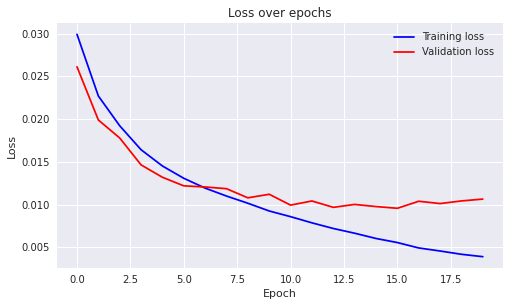

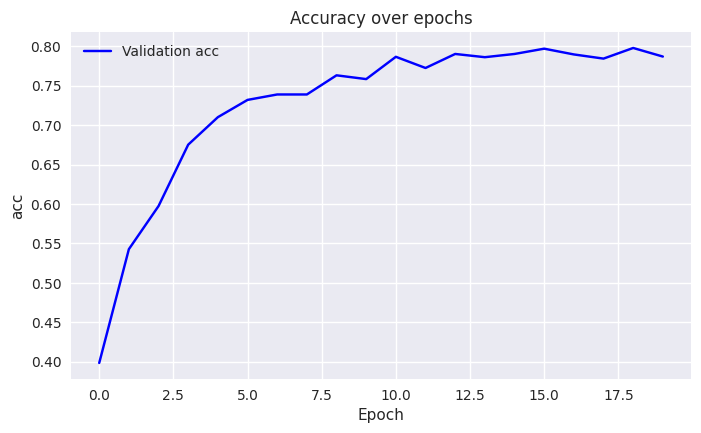

In [15]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'AlexNet - predictions')

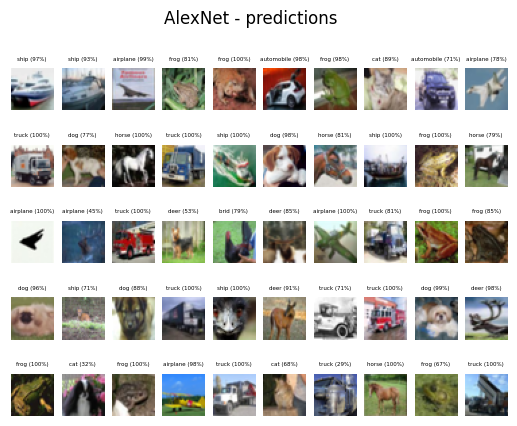

In [16]:
CIFAR_dict = {0: 'airplane',
              1: 'automobile',
              2: 'brid',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[int(torch.argmax(probs))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('AlexNet - predictions')


In [ ]:
"""
AlexNet
After 5 Epoch:
    Mine: 71.0%
    Pytorch: 64.4%
After 10 Epoch
    Mine: 75.9%
    Pytorch: 76.5%
After 15 Epoch
    Mine: 79.0%
    Pytorch: 80.5%
After 20 Epoch
    Mine: 78.7%
    Pytorch: 82.5%
存在一定程度过拟合
Epoch = 15 就已经不错了
structure:
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 96, 55, 55]          34,944
|    └─LocalResponseNorm: 2-2            [-1, 96, 55, 55]          --
|    |    └─AvgPool3d: 3-1               [-1, 1, 96, 55, 55]       --
|    └─MaxPool2d: 2-3                    [-1, 96, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 256, 27, 27]         614,656
|    └─LocalResponseNorm: 2-5            [-1, 256, 27, 27]         --
|    |    └─AvgPool3d: 3-2               [-1, 1, 256, 27, 27]      --
|    └─MaxPool2d: 2-6                    [-1, 256, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         885,120
|    └─Conv2d: 2-8                       [-1, 384, 13, 13]         1,327,488
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         884,992
|    └─MaxPool2d: 2-10                   [-1, 256, 6, 6]           --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Dropout: 2-11                     [-1, 9216]                --
|    └─Linear: 2-12                      [-1, 4096]                37,752,832
|    └─ReLU: 2-13                        [-1, 4096]                --
|    └─Dropout: 2-14                     [-1, 4096]                --
|    └─Linear: 2-15                      [-1, 4096]                16,781,312
|    └─ReLU: 2-16                        [-1, 4096]                --
|    └─Linear: 2-17                      [-1, 10]                  40,970
==========================================================================================
Total params: 58,322,314
Trainable params: 58,322,314
Non-trainable params: 0
Total mult-adds (G): 1.19
==========================================================================================
Input size (MB): 0.59
Forward/backward pass size (MB): 5.02
Params size (MB): 222.48
Estimated Total Size (MB): 228.09
==========================================================================================
parameters_count: 58322314
"""